In [63]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, LSTM
from keras.utils import plot_model
from reading_manager import read_csv
from keras.callbacks import EarlyStopping
from keras import regularizers
from matplotlib import pyplot as plt

## Analyzing model applications - machine learning

In [2]:
# Set up the paths
IMAGES_PATH = "C:/Users/mjgoj/Documents/pressure_images"
RECORDINGS_PATH = "C:/Users/mjgoj/Documents/artificial_recordings/recordings"

### 1. CNN

In [3]:
# Read the images
img_shape = (54, 54)
X, Y = [], []

for filename in os.listdir(IMAGES_PATH):
    img = cv2.imread(os.path.join(IMAGES_PATH, filename), cv2.IMREAD_GRAYSCALE)
    label = filename.split('_')[0]
    if img is not None:
        img = cv2.resize(img, img_shape)
        X.append(img)
        Y.append(label)
        
X = np.array(X)
Y = to_categorical(np.array(Y))
print('Shape (number of images, height, width):', X.shape)

Shape (number of images, height, width): (2755, 54, 54)


In [4]:
# Split the images into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
print('Train', y_train.shape[0], 'images : Test', y_test.shape[0], 'images')

Train 2204 images : Test 551 images


In [5]:
# Create the CNN model

# Create the input layer
input_shape = (img_shape[0], img_shape[1], 1)
model = Sequential()

# 1st block
# Add the first convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# Add the first pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd block
# Add the second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Add the second pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd block
# Add the third convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add the third pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the fully connected layer and softmax output layer
model.add(Flatten())
model.add(Dense(Y.shape[1], activation='softmax'))
# Output layer


In [6]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### 2. LSTM

In [49]:
# Read the recordings
X, Y = [], []


label = 0
for directory in os.listdir(RECORDINGS_PATH):
    print(directory)
    for filename in os.listdir(os.path.join(RECORDINGS_PATH, directory)):
        full_path = os.path.join(RECORDINGS_PATH, directory, filename)
        # Read the csv file
        sensor_positions, sensor_reading, time = read_csv(full_path)
        # Reduce one dimension
        sensor_reading = np.squeeze(sensor_reading)
        # Add the data to the lists
        X.append(sensor_reading)
        Y.append(label)
    label += 1

cuboid
cylinder
sphere


In [50]:
X = np.array(X)
print('Shape of the data (num_recordings, num_frames, num_sensors): ', X.shape)

Y = np.array(Y)
Y = to_categorical(Y)
print('Shape of the labels: ', Y.shape)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
print('Train', y_train.shape[0], 'recordings : Test', y_test.shape[0], 'recordings')

Shape of the data (num_recordings, num_frames, num_sensors):  (81, 50, 144)
Shape of the labels:  (81, 3)
Train 64 recordings : Test 17 recordings


### Create the LSTM model

In [87]:
# Set the hyperparameters
epochs = 120
batch_size = 16
units = 50
dropout_rate = 0.5
reg_lambda = 0.001  # Regularization factor

model = Sequential()

# 1st block
# Add the first LSTM layer
model.add(LSTM(
    units=32, 
    input_shape=(X.shape[1], X.shape[2]),
    kernel_regularizer=regularizers.l2(reg_lambda)
))

# Add the dropout layer
model.add(Dropout(dropout_rate))

model.add(Dense(
    units=units, 
    activation='relu', 
    kernel_regularizer=regularizers.l2(reg_lambda))
)

model.add(Dense(units=Y.shape[1], activation='softmax'))

In [85]:
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [61]:
# Compile the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
print(Y.shape)
print(X.shape)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

(81, 3)
(81, 50, 144)


In [62]:
# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping])

Epoch 1/120
4/4 [==============================] - 3s 182ms/step - loss: 1.2679 - accuracy: 0.3281 - val_loss: 1.2614 - val_accuracy: 0.3529
Epoch 2/120
4/4 [==============================] - 0s 21ms/step - loss: 1.2559 - accuracy: 0.2969 - val_loss: 1.2513 - val_accuracy: 0.3529
Epoch 3/120
4/4 [==============================] - 0s 16ms/step - loss: 1.2447 - accuracy: 0.3750 - val_loss: 1.2416 - val_accuracy: 0.2353
Epoch 4/120
4/4 [==============================] - 0s 21ms/step - loss: 1.2341 - accuracy: 0.3438 - val_loss: 1.2317 - val_accuracy: 0.2353
Epoch 5/120
4/4 [==============================] - 0s 19ms/step - loss: 1.2241 - accuracy: 0.3438 - val_loss: 1.2226 - val_accuracy: 0.2353
Epoch 6/120
4/4 [==============================] - 0s 16ms/step - loss: 1.2137 - accuracy: 0.3438 - val_loss: 1.2145 - val_accuracy: 0.2353
Epoch 7/120
4/4 [==============================] - 0s 21ms/step - loss: 1.2058 - accuracy: 0.3594 - val_loss: 1.2074 - val_accuracy: 0.2353
Epoch 8/120
4/4 [==

In [82]:
def plot_training_history(_history, metrics='accuracy'):
    
    train_color = '#0bb4ff'
    val_color = '#dc0ab4'
    
    # Plot the training history
    plt.plot(history.history[metrics], label='Training ' + metrics, color=train_color)
    # Add the trend line
    z_train = np.polyfit(
        np.arange(len(history.history[metrics])), 
        history.history[metrics], 
        deg=1
    )
    p_train = np.poly1d(z_train)
    plt.plot(
        np.arange(len(history.history[metrics])), 
        p_train(np.arange(len(history.history[metrics]))), 
        linestyle='--',
        color=train_color
    )
    
    # Plot the validation history
    plt.plot(history.history['val_' + metrics], label='Validation ' + metrics, color=val_color)
    # Add the trend line
    z_val = np.polyfit(
        np.arange(len(history.history['val_' + metrics])), 
        history.history['val_' + metrics], 
        deg=1
    )
    p_val = np.poly1d(z_val)
    plt.plot(
        np.arange(len(history.history['val_' + metrics])), 
        p_val(np.arange(len(history.history['val_' + metrics]))), 
        linestyle='--',
        color=val_color
    )
    
    plt.legend()
    
    # Add the labels
    plt.title('Training and validation ' + metrics)
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    
    plt.show()

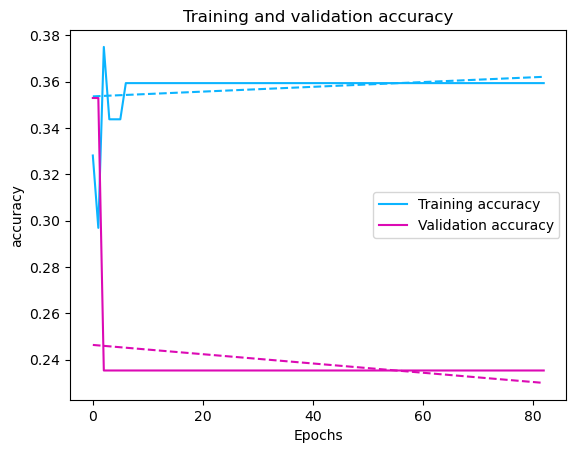

In [83]:
plot_training_history(history, metrics='accuracy')